# MLP and NeuMF RecSys using Keras Embedding Layer

### The models used in this notebook have been defined and optimized in Keras_Models/Hyperparameter_Optim folder in the repository. The models built there will be imported in this notebook for predictions.

This notebook contains an implementation of Collaborative Filtering using Neral Networks and Deep Learning architectures. The model aims to make accurate video game recommendations to users of the Playstation 4 based on their previour reviews and ratings.

The models will be built using the Keras Library

Keras Documentation : https://keras.io

The user review data used in this notebook has been obtained from a popular video game review site called Metacritic.

## Data Preprocessing and Preparation of Test set

In [1]:
#Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import load_model

#Library to load images for illustration purposes
from IPython.display import Image

#for buidling set with every user-game combination
from itertools import product

Importing the  pre-saved train, validation and test sets. The dataset has been split using the same method explained in the SVD model, ensuring that every user and every item is represented at least once in the trainset. In order to maintain consistency, I have pre-saved the splits since optimization is done in a separate file. 

In [2]:
#For top n predictions
trainset = pd.read_csv("trainset.csv")
validset = pd.read_csv("validset.csv")

#For testing the model
testset = pd.read_csv("testset.csv")

All of the data imported has already been split in a 80:10:10 ratio in the appropriate manner with the trainset having at least one rating from every user and every game. Mean normalization and feature scaling have also been applied to these sets. 

In addition, the user and game encodings have also been added to the datasets in separate columns.

In [3]:
trainset.head()

,User_Name,Game_Name,Rating,User_Enc,Game_Enc
0,User 293,Red Dead Redemption 2,1.0,0,0
1,User 801,Red Dead Redemption 2,0.1,1,0
2,User 1120,Red Dead Redemption 2,1.0,2,0
3,User 2314,Red Dead Redemption 2,1.0,3,0
4,User 2869,Red Dead Redemption 2,0.9,4,0


In [4]:
testset.head()

,User_Name,Game_Name,Rating,User_Enc,Game_Enc
0,User 67,Red Dead Redemption 2,0.5,16,0
1,User 939,Red Dead Redemption 2,1.0,21,0
2,User 2940,Red Dead Redemption 2,0.9,29,0
3,User 82,Red Dead Redemption 2,0.5,35,0
4,User 2203,Red Dead Redemption 2,0.9,55,0


In [5]:
#Splitting the model test set into X_test(inputs) and y_test(outputs)
X_test = testset[["User_Enc", "Game_Enc"]]
y_test = testset[["Rating"]]

X_valid = validset[["User_Enc", "Game_Enc"]]
y_valid = validset[["Rating"]]

X_train = trainset[["User_Enc", "Game_Enc"]]
y_train = testset[["Rating"]]

In [6]:
X_test.head()

,User_Enc,Game_Enc
0,16,0
1,21,0
2,29,0
3,35,0
4,55,0


In [7]:
y_test.head()

,Rating
0,0.5
1,1.0
2,0.9
3,0.5
4,0.9


# Multi-Layer Perceptron(MLP) Model for Collaborative Filtering

HyperParameters to tune and ranges for the MLP Model with explanations for each:

The ranges for the hyperparameters have been selected using trial and error.

-> Number of user embeddings, range (30, 60) : Hidden feature vector length for users

-> Number of game embeddings, range (20, 50) : Hidden feature vector length for items

Embeddings are essentially hidden numeric features that the model learns using the data. However, embeddings differ from normal features in a dataset in the sense that they contain a degree of association. For instance, similar users will have more similarity betweeen their embeddings than users that are not alike. The same rule applies for game embeddings. The number of embeddings dictates the length of this vector, or how many hidden features the model will try to learn for each user and each item. 

In the case of an MLP model, the user and game vectors do not need to be of the same length. This will be explained in more detail in the model architecture.

-> Hidden Layer count, range (1, 2): The number of  hidden layers in the model. In most cases, 1 hidden layer will suffice to find every hidden trend in the dataset. However, in some applications, addition of extra layers will improve the model.

-> Neuron Count per hidden layer, range (4, 128): The number of neurons per hidden layer. We will be using the same number of neurons per hidden layer. It is assumed that the number of neurons should decrease with each successive layer rather than maintain the same number of neurons. You could do this, however, in most cases it does not make a difference and the results end up being more or less similar.

-> Embeddings initialization method : This deals with how the embeddings are given their starting values. The model will start at an arbitrary state with some initilial values and with every iteration, the values of the embeddings will be updated and brought closer and closer to the optimal value. There is a lot of debate on which method works best in this case, it all comes down to a matter of preference. You can read more about this by following the links here : https://datascience.stackexchange.com/questions/13061/when-to-use-he-or-glorot-normal-initialization-over-uniform-init-and-what-are

-> L2 Regularization for embeddings, range (3e-8, 1e-6) : Regularization in this case is similar to the regularization seen in the SVD model. It deals with the bias/variance tradeoff and prevents the model from overfitting or underfitting depending on the value given to it. If regularization is too low, the model will adhere to the training set too closely and will not be able to generalize well to new data that is thrown at it. Regularization is especially important for deep learning models.

-> Dropout value per layer, range (0, 0.4) : A Dropout layer is another form of regularization, I wasn't kidding when I said regularization is crucial in deep learning models. Dropout layers hold a value between 0 and 1 and sets that fraction of network parameters in that particular layer to 0, thereby preventing these parameters from contributing to the model in that particular iteration. I won't go into too much detail on this, because it suffices to understand that its basically just regularization in another form.

-> Hidden layer activations : Activations essentially allow you to influence or shape the outpus from each layer. In this case, we're dealing with a multiple regression problem, and for regression, a linear activation like ReLu is used. In practice, the outputs from each layer are passed into the activation function specified for each layer. The output from this activation function is the output for the whole layer. 

-> Output layer activation : The activation function for the output layer. This is where activations become increasingly important because the output may have some constraints. For instance, the output from the model may be a probability, in which case it should be between 0 and 1. It may be a regression problem with a minimum and maximum output value (which is the case for this application). Hence we need to choose the appropriate activation with the specified constraints.

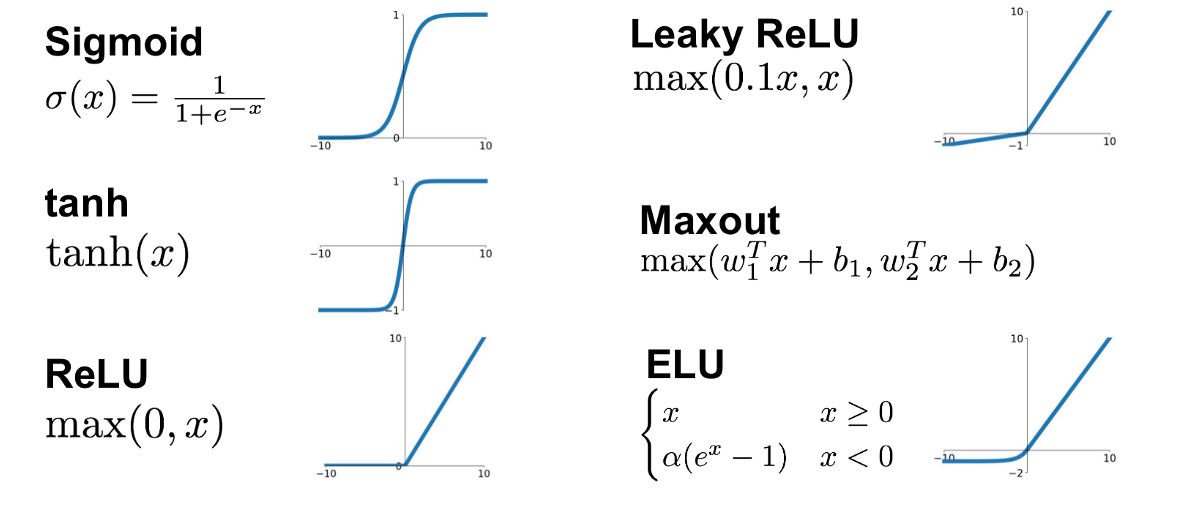

In [1]:
Image(filename='Activations.png') 

-> Optimizer (SGD, Adam) : The optimizer determines the method using which the model converges to the best set of parameters. It determines the method and how fast minimum error is achieved by the model. When choosing optimizers, there is a speed/convergence quality tradeoff to keep in mind. Some optimizers are faster than others but may not produce the best results. In this case, SGD and Adam produces the best convergence quality, while adam is faster without too much loss of quality, but SGD gives more quality convergence.

-> Learning rate for optimizer (and momentum if SGD or RMSprop), lr_range_adam (3e-6, 1e-4), lr_range_sgd(0, 0.1), momentum_sgd (0, 1) : The learning rate determines the step size taken by the optimizer when reaching the optimal minimum error point. Check out the SVD_model notebook for a more detailed explanation about this. 

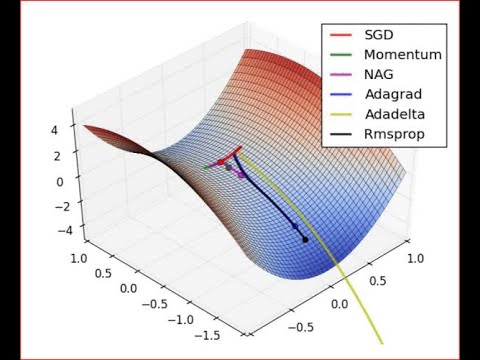

In [2]:
#Horizontal axis is the error
Image(filename='opt.png')

-> Number of iterations for convergence : This determines how many times the algorithm will run to find the optimal solution. In this case, we don't have to specify this hyperparameter since I will be using an early stopping mechanism to stop running the model when the lowest validation error is achieved. Check out the opimization code to see how this is done using callbacks.

Since there are several hyperparameters to tune, I have used a library called hyperas to train the model for different combinations of hyperparameters and have saved the MLP model that returned the lowest validation error. The optimization has been carried out in a separate python file called "MLP_hyperasTune.py" under the optimization folder. Running this file will carry out a random search over the specified ranges and choices of hyperparameters and return the best model found during the run. The script also saves the run logs so you can visualize the learning curves of all the optimization runs to check out which model produced the best results. Some of these optimization logs have also been included in the repository.

### Visualizing optimization runs using Tensorboard

In order to view the learning curves and study the performance with different combinations of hyperparameters, I have plotted learning curves using a tool called tensorboard. Tensorboard logs every run of the model and saves it in different folders that can be accessed using a tensorboard server. Check out the readme file in the optimization folder to understand how to use this resource. I have shown a few exmamples below.

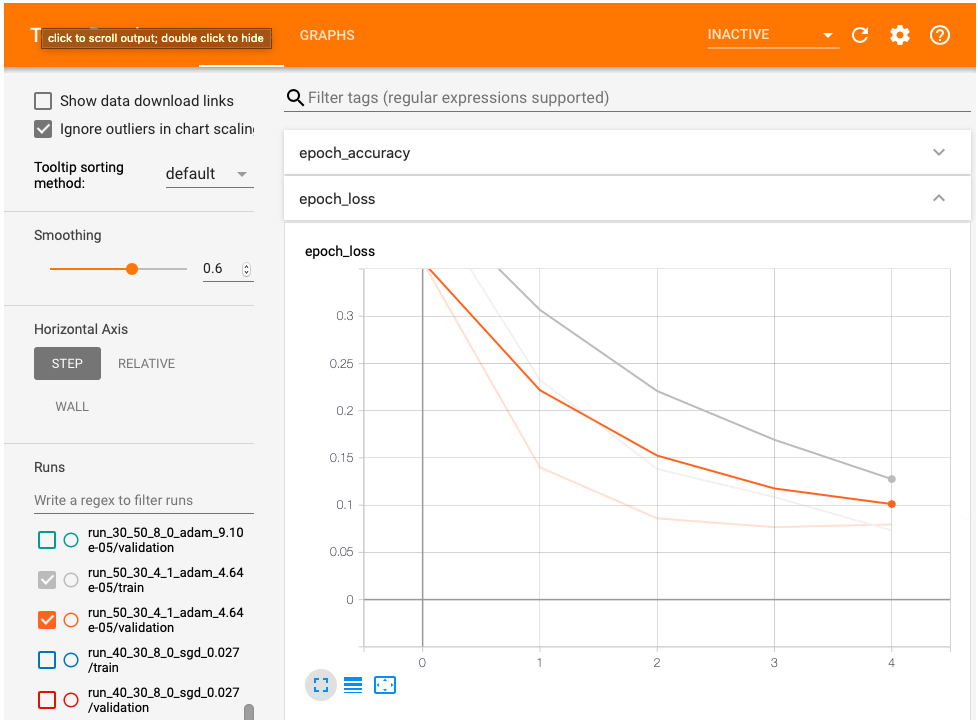

In [39]:
#Check out the readme in the optimization folder for more details on how to use tensorboard
%load_ext tensorboard
%tensorboard --logdir=./mlp_run_logs --port=6006

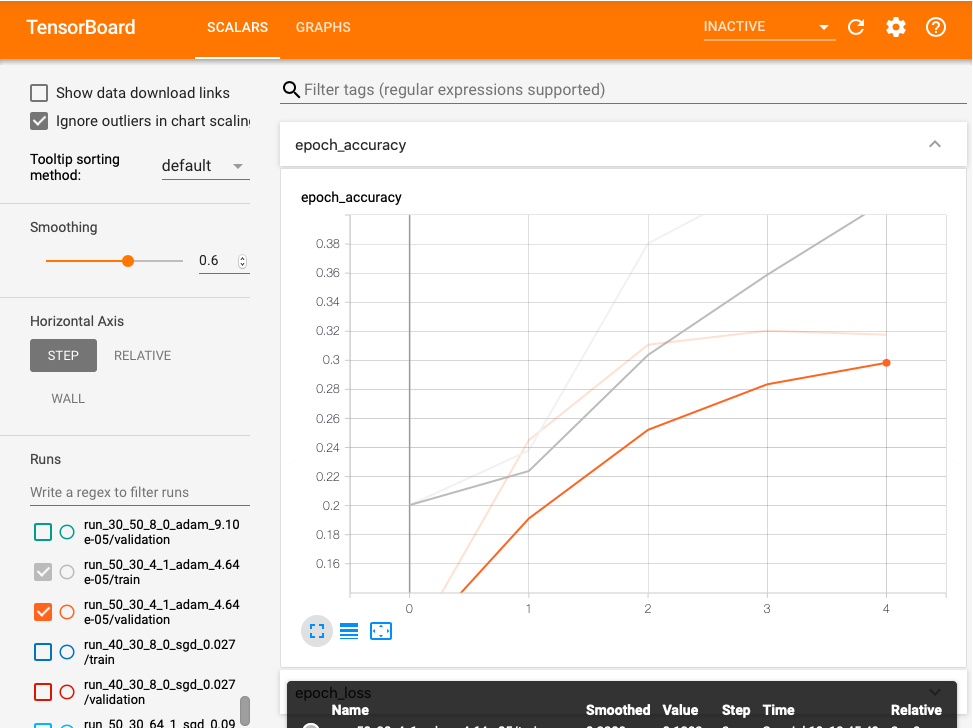

In [29]:
#Shutting down the tensorboard server
!kill

You may notice that in all of these models, the trainset accuracy is always higher than the validation accuracy. This is because early stopping is enabled and training is stopped before overfitting occurs. If the training had continued beyond this point, the trainset error would be miniscule, while the validation error would shoot up, this indicating overfittings and the inability of the model to generalize well to new data.

### Importing the best MLP model found during optimization

In this notebook, I will only import the best model found when optimizing the hyperparameters rather than defining the whole network all over again. Keras provides a method to save the model including all the parameters and weights, and the model can be loaded elsewhere for later use. I have not been able to upload the model to the repo due to its size. However, you can run the optimization script and it will automatically save the best model in the same directory once its done.

In [8]:
#Loading the best model found during optimization
mlp_model = load_model("MLP_RecSys_Model.h5")

In [9]:
#Model architecture summary
mlp_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Game_Name_Input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
User_Name_Input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Game_Embeddings (Embedding)     (None, 1, 40)        68920       Game_Name_Input[0][0]            
__________________________________________________________________________________________________
User_Embeddings (Embedding)     (None, 1, 40)        4533560     User_Name_Input[0][0]            
____________________________________________________________________________________________

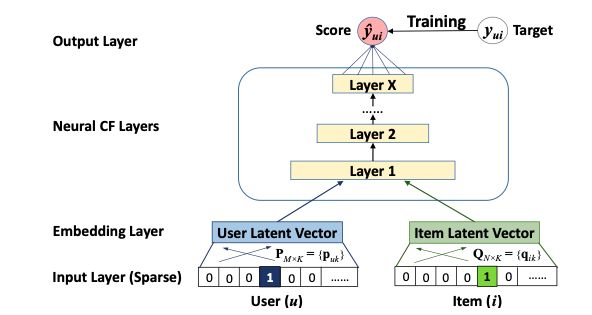

In [4]:
Image(filename='mlp.png')

Explanation of model architecture : 
-> Input layers : We have two inputs in this case, one for the user encoding and one for the game encoding. Each input layer is connected to an embedding layer.

-> Embedding layer : The embedding layer initializes the embeddings for each user. It takes the input from the input layer and outputs an embedding vector of length 40. This means that each user and each game has 40 hidden features. The embedding layers then outputs these embeddings for each user and game.

-> Flatten layer : The embeddings have to be flattened or reshaped into a flat vector before passing them into deeper layers. This may be a little confusing but think of it as making a new row of examples from a single input example, which needs to be flattened or reshaped to resemble a single row. Again, this applies to users and games.

-> Concatenation layer : Now we have a user vector of length 40 and a game vector of length 40 for each user and game. Each of these vectors mimic features or columns in a dataset so they need to be joined together like a normal dataframe when making predictions. The concatenation layer simply joins these embeddings. Think of it as creating a new dataset with the same number as rows (examples) as the original training set. However, instead of two columns (user and game encoding) and the output, we now have 80 numeric columns (40 embeddings for user and game each) and one output. So now these columns will be used to predict the output.

-> Dense layers : These layers are the hiddent layers where the actual learning takes place. The features are fed into the dense layers and they produce and output for each example. In this case the dense layer has 64 neurons, so for each example, there would be 64 outputs from this layer.

-> Dropout layer : Regularization layer applied after every dense layer in the model. Every dense layer uses a relu activation. This is not clear from the diagram.

-> Output layer : This is the final output from the model, and the number of neurons in this layer depends on how many outputs we have. In this case we have only 1 so we have 1 neuron. This output layer also uses the relu activation however the output is constrained to the range [0, 1] since the ratings lie in this range.

In summary, for each training example given to the model, it creates a 80 features (40 per user and game), concatenates it, and uses these features to predict a single output.

Also note that the optimization process has produces a model with only 1 hidden layer.

#### You will probably come across a lot of cases where a sigmoid activation function is used in the output layer for recsys models. However, a ReLu activation with constraints seems to be better in theory. Here's my reasoning for this. A sigmoid activation function gives an output in the range [0, 1], however, the output drops below 0.5 only when the input into the sigmoid function is below 0. In this regression problem, the outputs from each layer are ALWAYS going to be positive because each hidden layer is using the ReLu activation. This means that if a sigmoid function is used as the output layer, the output will never drop below 0.5, thereby making the outputs biased towards higher ratings. For this reason, I have used a ReLu activation for the output and constrained it to the range [0, 1].

## Reporting testset accuracy using the MLP model

Now that we have the model ready with all the parameters and hyperparameters tuned, we can use it to make predictions.

In [10]:
mse = mlp_model.evaluate([X_test.Game_Enc, X_test.User_Enc], y_test.Rating)[0]
print("Test Set Error (RMSE): ", mse ** 0.5)

241/241 [==============================] - 3s 11ms/step - loss: 0.0762 - accuracy: 0.3381
Test Set Error (RMSE):  0.2760819219830846


#### We get an RMSE of about 0.276 (may vary due to random initialization of train and test sets) which corresponds to an MSE of 0.0762.

These results show no improvement over the results produced by the matrix factorization models.

The hyperparameters have been tuned to give the best performance for the specified architecture. The only architecural modification that was explored in the optmization process was the addition of more dense layers and neurons in the model. It is entirely possible that there exists an architecture that could slightly improve the results, given the same data.

## Scope of imporvement:

-> Again, one way to improve the results would be to get more user rating data. 

-> The model can also be improved is by retrieving the review timestamp and the review text. With the user text data in hand, we can use Natural Language processing(NLP) to filter out the spam reviews and improve the recommendations. 

-> With the user rating timestamp in hand, we can implement Recurrent Neural Networks(RNN's). RNN's are very useful when dealing with time series or sequential data. In our case, it will improve recommendations by providing the model with a sequential aspect of evaluation of the data which does not exist without the timestamps.

-> The last method (which I will implement below) is to combine the matrix factorization and MLP models to produce better results.

Implementing the above improvements could potentially make the model better than the Matrix Factorization models as the surprise package does not provide a way to incorporate user review text and timestamp data.

Below I will implement a model that combines the matrix factorization and MLP models.

## Top-N recommendations using MLP

In this section I will retrieve the top n games recommended to each user. The code for this will be included below however I won't run it here due to the size of data generated, my device simply can't handle it and it required several gigabytes of storage.

The below lines of code will generate the top n recommendations and place it in a dataframe.

I have defined two functions below. The build_full_set() function builds a dataset containing every user-item pair that has not been rated yet. The top_n_recs() function builds the actual recommendations dataset. These two functions will be used to generate new recommendations for each user.

In [11]:
def build_full_set(data):
    """
    Function to build every combination of user-item pairs from a given set of users and items.
    
    Arguments:
    -> data : dataset containing the user encoded and item encoded pairs and Ratings(optional) as columns with the 
       column names as  "User_Enc" and "Game_Enc" respectively. 
       
    Note : Every user-item pair passed in this parameter must be part of the existing dataset that was used to train,
    validate, and test the model. This is to ensure that the function returns only user-item pairs that have not been
    rated yet.
    
    
    Returns: 
    -> user_item_pairs : pandas dataframe containing every possible combination of users and items passed
       to the function
    """
    
    #Retrieving all unique users and games and placing them in a dataframe
    user_game_pairs = pd.DataFrame(data["User_Enc"].unique())
    user_game_pairs["Game_Enc"] = list(data["Game_Enc"].unique())

    #Finding every user-game pair
    user_game_pairs.columns = ["User_Enc", "Game_Enc"]
    user_game_pairs = pd.DataFrame(product(user_game_pairs['User_Enc'], user_game_pairs['Game_Enc']))

    #dropping all the pairs that have null values
    user_game_pairs = user_game_pairs.dropna()
    
    #forming the pre rated pairs that need to be removed from the user-item pairs
    to_remove = pd.DataFrame(data[["User_Enc", "Game_Enc"]])
    to_remove.columns = ["User_Enc", "Game_Enc"]
    
    #Removing all the pairs that have already been rated
    user_game_pairs = user_game_pairs[~user_game_pairs.isin(to_remove)].dropna()
    
    return user_game_pairs

In [12]:
def top_n_recs(user_game_pairs, n = 5):
    """
    Function to buid a dataframe containing users as columns and game recommendations for each user as cells.
    
    Arguments: 
    -> user_game_pairs : User-item pair dataframe on which predictions have been made. Note that this dataframe 
       should also contain the predictions made by the relevant model. Also note that the users and items passed 
       need to be the encodings and not the actual string values.
       
    -> n : Number of games to recommend, default is 5
    
    Returns: 
    -> recommendations : pandas dataframe containing user encodings as column headers and each column containing
       n cells corresponding to the game recommendations.
    """
    
    users = list(user_game_pairs["User_Enc"].unique())
    recommendations = {}
    
    #Iterating through every user
    for u in users:
        #Locating all entries of an individual user
        user_ratings = user_game_pairs.loc[user_game_pairs['User_Enc'] == u]

        #Sorting the ratings in descending order and selecting the first 5 games from the sorted dataframe
        user_ratings = user_ratings.sort_values("Rating", axis=0, ascending=False, kind='quicksort')
        user_top_ratings = user_ratings[:n]

        #Placing the recommendations for the user in a dictionary with user as the key
        user_top_games = list(user_top_ratings["Game_Enc"])
        recommendations[u] = user_top_games
        
    #Coverting the dictionary into a dataframe with users as the columns and cells containing recommended games.
    recommendations = pd.DataFrame(recommendations)
    
    return recommendations

In [ ]:
#Building the full dataset containing all user-item pairs that have already been rated
full_dataset = pd.concat([trainset,validset, testset]).drop_duplicates().reset_index(drop=True)
full_dataset = full_dataset.drop(["User_Name", "Game_Name"], axis = 1)

In [ ]:
#Building the user-item pairs on which predictions will be made
mlp_user_game_pairs = build_full_set(full_dataset)

Now we have ratings for every single user-game pair in the dataset, except for the ones that have been rated previously. From here we simply need to make predictions using our model and pick the n highest ratings for each user as recommendations. In this case I will take the top 5 recommendations.


In [ ]:
#Making predictions on all remaining user-game pairs
mlp_predictions = mlp_model.predict([mlp_user_game_pairs.Game_Enc, mlp_user_game_pairs.User_Enc])

#Adding the predictions as a new column in the dataframe
mlp_user_game_pairs["Rating"] = mlp_predictions

In [ ]:
#Calling the function defined above to make recommendations
mlp_recommendations = top_n_recs(mlp_user_game_pairs)
mlp_recommendations.head()

# Neural Matrix Factorization (NeuMF) Model for Collaborative Filtering

The neural matrix factorization model consists of two sections; the matrix factorization section and the MLP section. The inputs and the MLP section architecture of this model is exactly the same as the one we defined earlier, except the hyperparameters may vary. Hecne I will only go into detail about the MF section of the model below.

#### Hyperparamters to tune:

#### MLP Section : 
-> All the hyperparamters specified for the MLP model : All the hyperparaters for the MLP model are also included in this model.

-> The only difference in this MLP section is that the ouput layer has 8 neurons instead of just 1 for compatibiltiy purposes. The output from the MLP section has to be concatenated with the output from the MF section.

#### MF Section : 
-> Number of user and game embeddings for the matrix factorization section: The emebedding concept in the matrix factorization section of the model is very similar to the one I explained earlier with one key difference. Instead of concatenating the embeddings together and using them as a set of columns, we will take the dot product of the vectors. The dot product would produce a single output for each example which corresponds to the ratings gives by that user for that game.

In this case, since the user and game embeddings are multitplied together, they must be of the same size for compatibility.

-> Embedding initialization : Same as the one defined earlier

-> Ouptut activation


#### Combined section:

-> Number of hidden layers 

-> Number of neurons per hidden layer

-> Layer activations

-> Output layer activation

Note that the MLP and MF sections of the model will not be sharing the same embeddings. The two sections will have their own sets of embeddings to work with. This is because we don't want each one to influence the other.

Again, these hyperparameters have been tuned using hyperas and optimization logs have been saved.

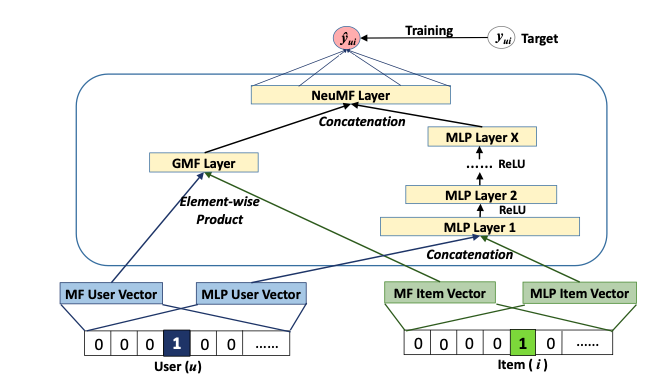

In [3]:
#Visualizing the basic model architecuture
Image(filename='neumf.png')

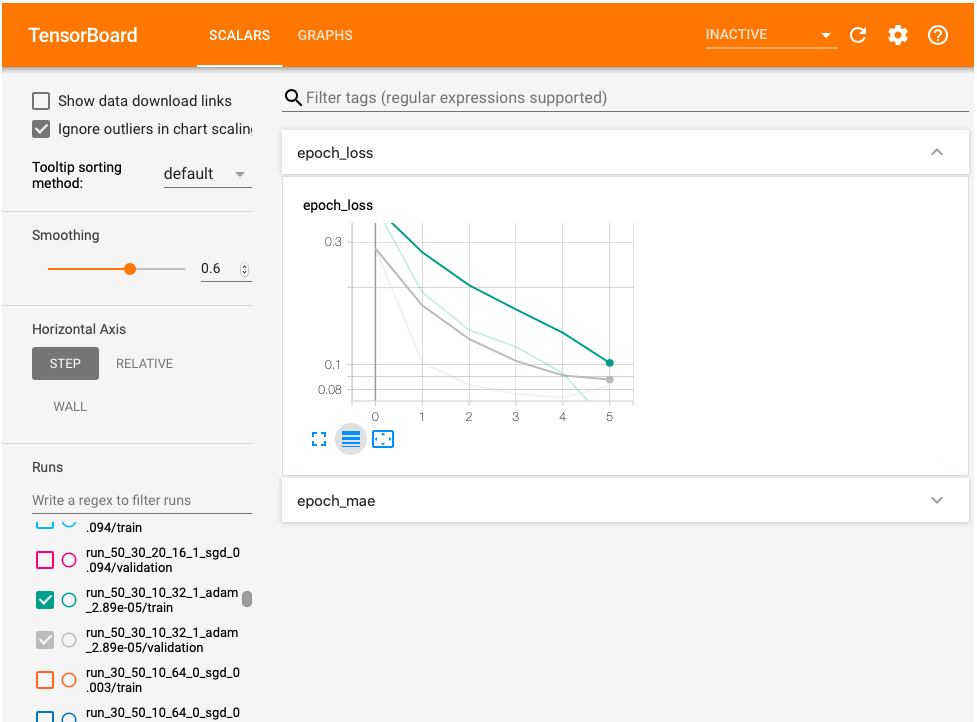

In [41]:
#Visualizing the NeuMF optimization logs using tensorboard

%load_ext tensorboard
%tensorboard --logdir=./neuMF_run_logs --port=6006

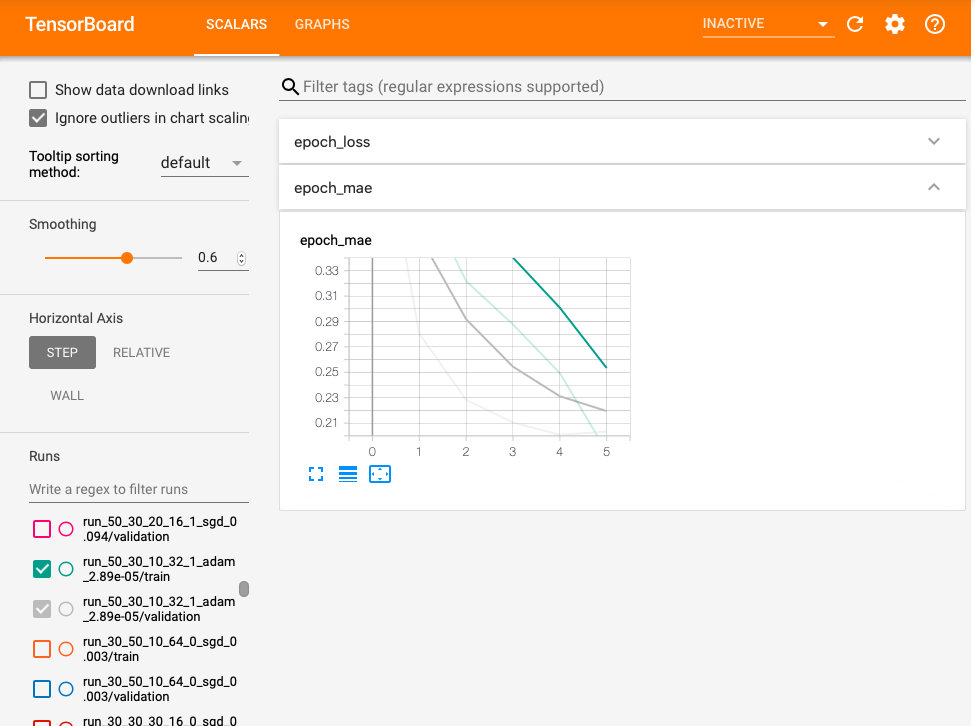

In [31]:
#Shutting down the tensorboard server
!kill

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


### Importing the best NeuMF Model found during Optimization

Run the optimization script and it will automatically save the best NeuMF model in the same directory once its done. You can then import this model here to make predictions

In [12]:
#Importing the model
neuMF_model = load_model("NeuMF_RecSys_Model.h5")

In [13]:
#Model Architecture summary
neuMF_model.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Game_Name_Input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
User_Name_Input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Game_Embeddings_MLP (Embedding) (None, 1, 40)        68920       Game_Name_Input[0][0]            
__________________________________________________________________________________________________
User_Embeddings_MLP (Embedding) (None, 1, 30)        3400170     User_Name_Input[0][0]            
___________________________________________________________________________________________

Explanation of MF and output section of the model:

-> Input layer : Same as the previous model

MF Section architecture : 

-> Embedding layer for each user and item : Works the same way as the embedding layer for the MLP section. However in this case the user s and items must have the same number of embeddings, which is 10 in this case.

-> Flatten layer : Again, same concept as explained earlier.

-> Dot layer : This layer in the MF section simply takes the dot product of the user and item embedding vector and produces an ouptut.

-> Output_MF : The output layer is just the result of the dot product layer activated using the relu function and constrained to the range [0, 1]

As you can see, this section is a fairly simple architecture and does not involve any deep learning. The deep learning is handled by the MLP and final layers.

NeuMF Section architecture : 

The neuMF section is the part that combines both the MLP and MF sections of the model.

-> Concatenation layer : This layer concatenates the outputs of the MLP and MF sections of the model and treats these as a set of features, similar to how it works in the concatenation layer of the MLP section although not exactly the same.

-> Ouptut layer : Takes in the concatenated outputs of the MLP and MF layers. It is basically just a dense layer with 1 neuron. This output is then fed into a relu activation function and constrained to the range [0, 1]. This is the final output from the whole model.

The extra unnamed layers that you see are just the unnamed activation layers where the relu function with ranges are applied.

## Reporting testset accuracy using NeuMF Model

In [14]:
mse = neuMF_model.evaluate([X_test.Game_Enc, X_test.User_Enc], y_test.Rating)[0]
print("Test Set Error (RMSE): ", mse ** 0.5)

241/241 [==============================] - 2s 10ms/step - loss: 0.0751 - mean_absolute_error: 0.2072
Test Set Error (RMSE):  0.2740228654307609


#### We get an RMSE of about 0.274 which corresponds to an MSE of 0.0751, which is a slight improvement over the previous model but is not very significant. 

This was surprising to me since I expected a significant improvement. I expected the MLP and MF layers to reinforce and learn from each other and thereby become more effective as a unit but this did not turn out to be the case. Hence, the other avenues mentioned above will need to be explored in order to improve the model and its recommendations.

Again, there may be a different architecture that could improve the results slightly. However, the only ways to create a significant improvement is to implement NLP and RNN's as I had mentioned earlier. NLP and RNN's are something I will work on implementing in the future.

## Top n recommendations using NeuMF

The top n recommendations in this case can be made using the exact same method as explained under the mlp model. The only difference is that the predictions need to be made using the neuMF model.

Again, I won't be running this code here because it is computationally way too expensive for my device to handle. Running the below cells will retrive a dataframe containing every user as columns with the recommendations for each of them.

In [ ]:
#Building the user-item pairs on which predictions will be made
nmf_user_game_pairs = build_full_set(full_dataset)

In [ ]:
#Making predictions on all remaining user-game pairs
nmf_predictions = mlp_model.predict([nmf_user_game_pairs.Game_Enc, nmf_user_game_pairs.User_Enc])

#Adding the predictions as a new column in the dataframe
nmf_user_game_pairs["Rating"] = nmf_predictions

In [ ]:
#Calling the function defined above to make recommendations
nmf_recommendations = top_n_recs(nmf_user_game_pairs)
nmf_recommendations.head()

End of notebook